In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.agents.constant import AllC, AllD
from society.agents.qlearning import DoubleTabularQLearner, TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.simulations.adaptive import AdaptiveSimulation
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]

Run 1:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (127): 36976 (0.9513814684780949, CCCCCCCCCCCCCCCC)
WORST AGENT (18): 28061 (0.5094747551825003, DDDDCCCCCCCCCCCC)


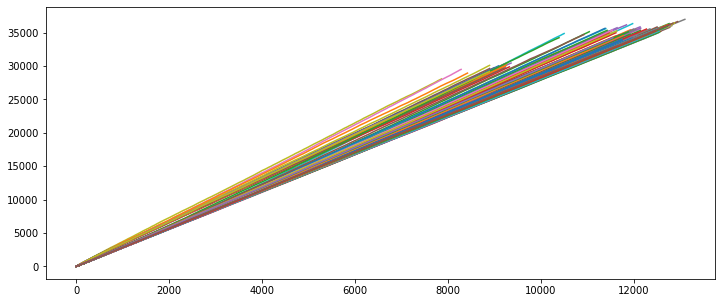

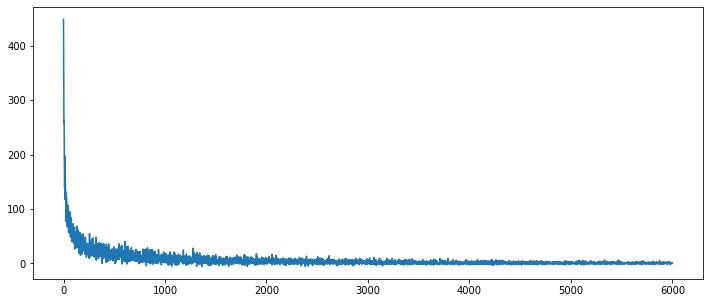

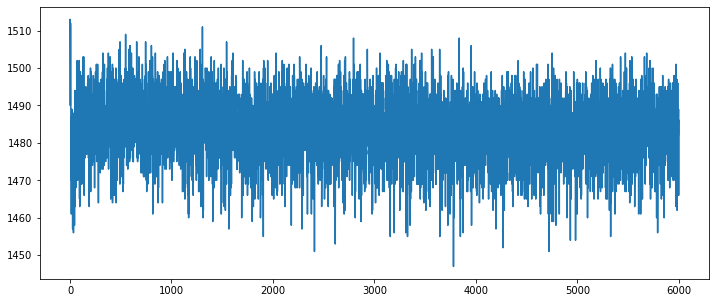

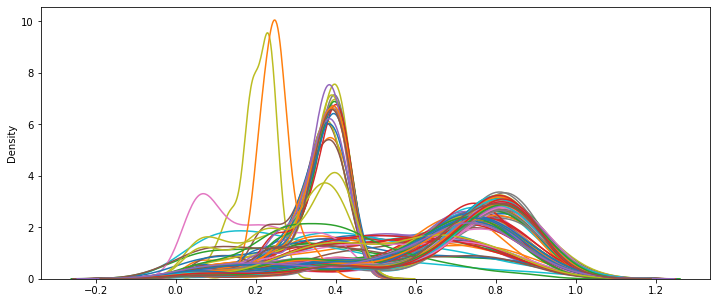

Run 2:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (240): 36413 (0.9508272769444874, CCCCCCCCCCCCCCCC)
WORST AGENT (190): 26728 (0.3279144087814367, DCDCDCCCCCDCCCCC)


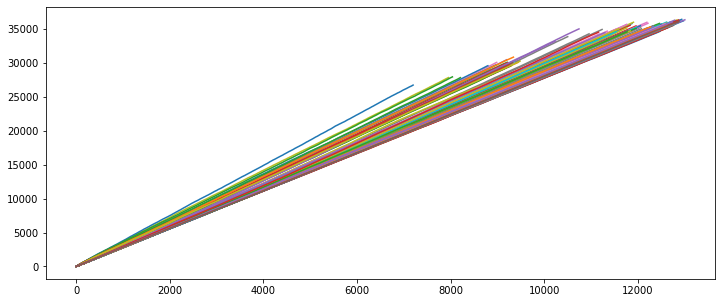

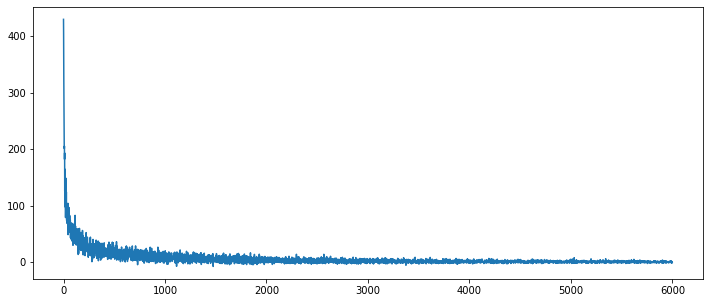

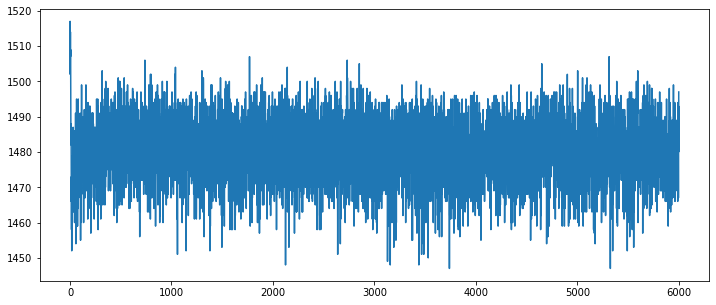

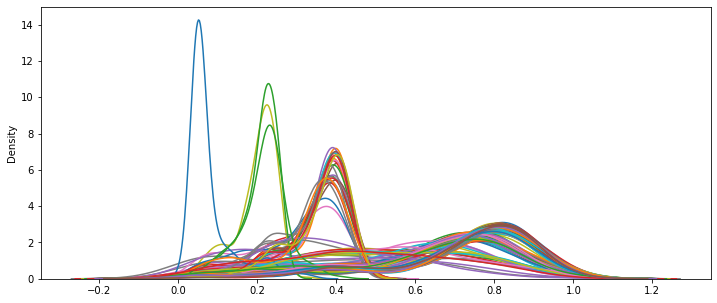

Run 3:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (29): 36712 (0.9496898690558235, CCCCCCCCCCCCCCCC)
WORST AGENT (130): 28028 (0.5266766392420843, DCDDCCCDCCCCCCCC)


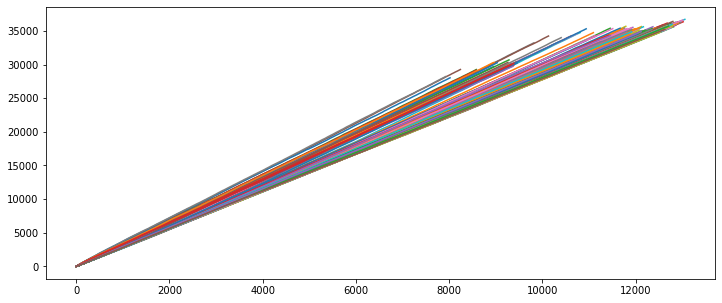

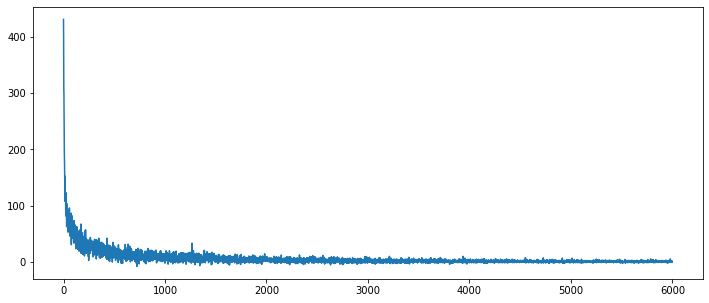

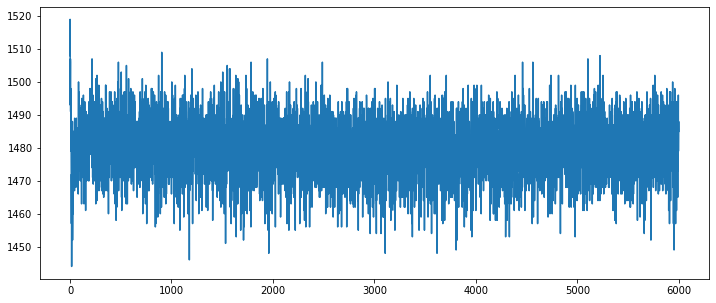

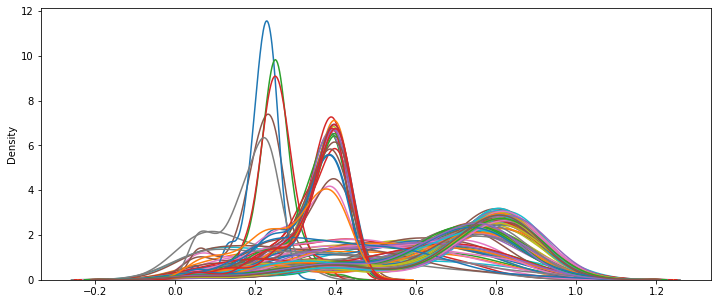

Run 4:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (77): 36825 (0.9495984703632887, CCCCCCCCCCCCCCCC)
WORST AGENT (224): 27249 (0.4498189342990171, DCDCCCCCDDCCCDCC)


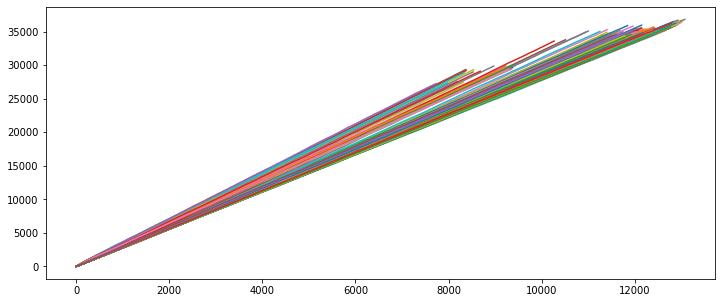

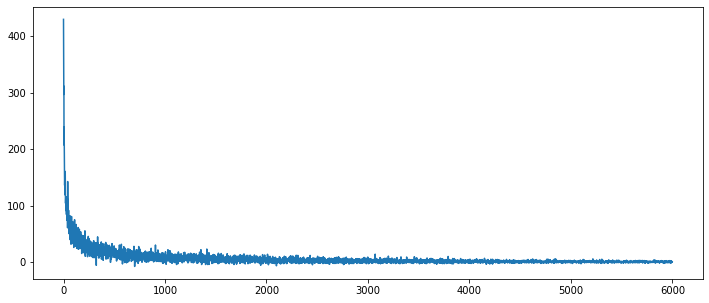

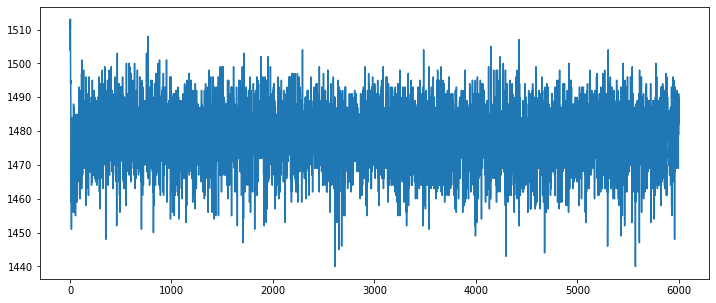

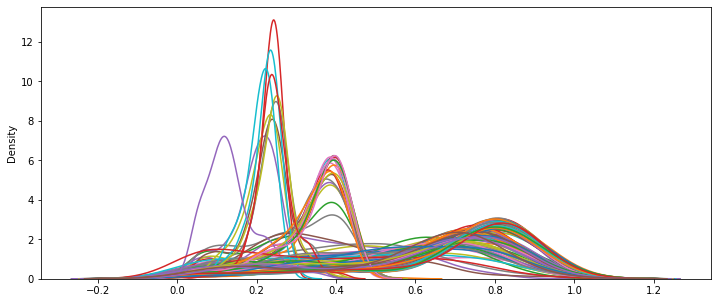

Run 5:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (191): 36486 (0.945865369527695, CCCCCDCCCCCCCCCC)
WORST AGENT (156): 26722 (0.45293881376355605, DCDCCCCDDCCCCCCC)


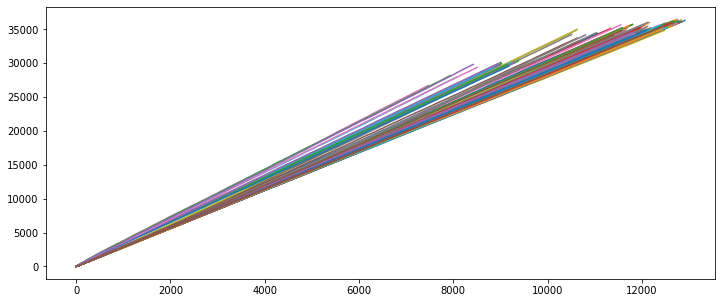

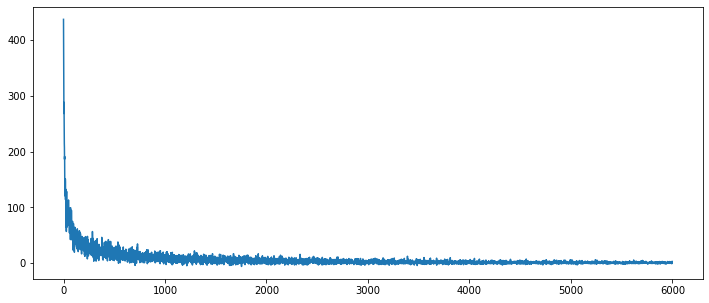

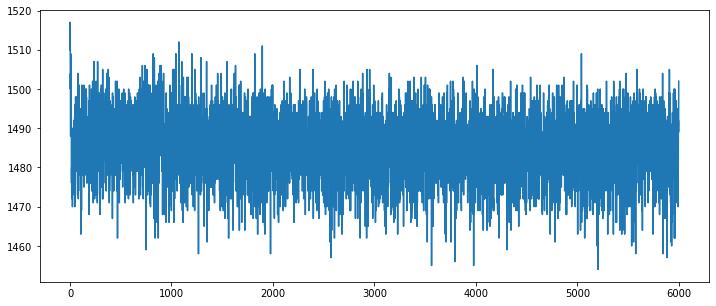

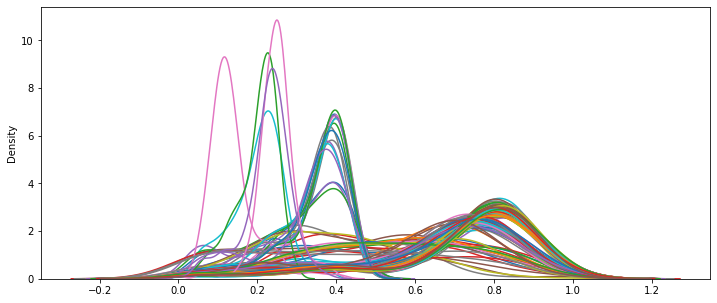

Run 6:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (27): 36711 (0.9433774581069707, CCCCCDCCCCCDCCCC)
WORST AGENT (197): 26347 (0.3522167487684729, DCDCCDCCDCDCCCCC)


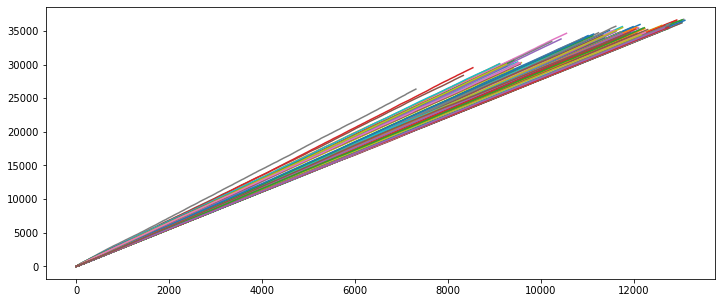

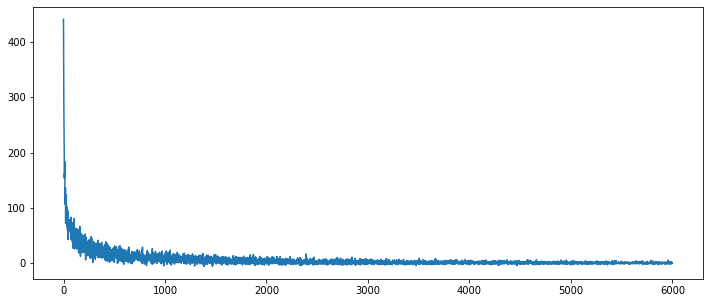

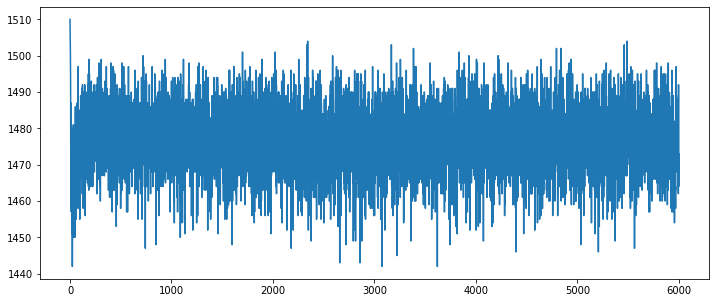

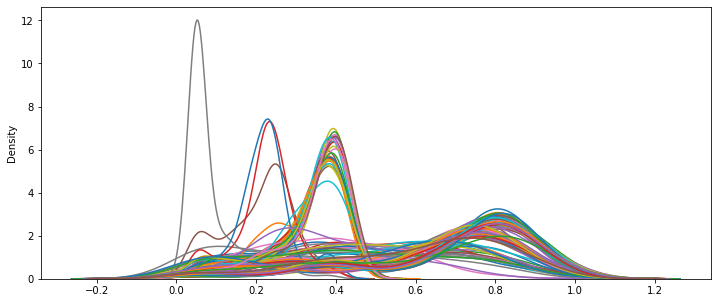

Run 7:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (186): 36436 (0.9491538580965688, CCCCCCCCCCCCCCCC)
WORST AGENT (145): 27748 (0.5537627786673236, DCDCCCDCCCCCCCCC)


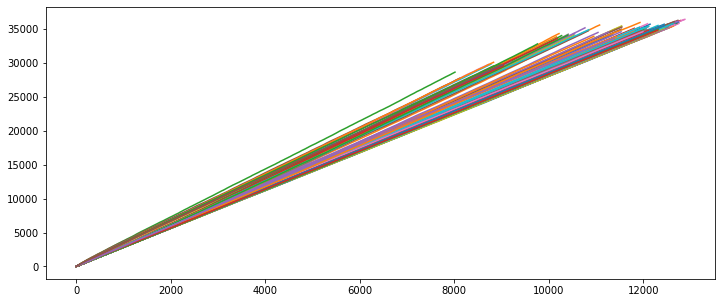

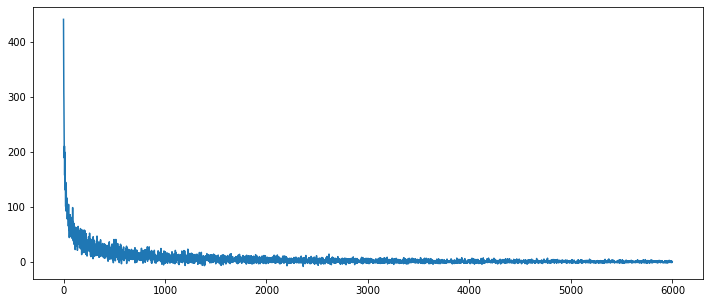

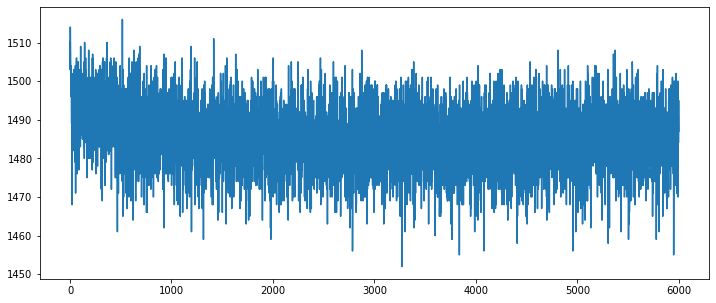

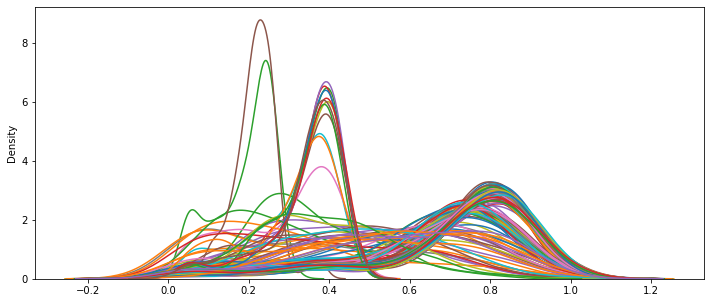

Run 8:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (26): 36675 (0.9527456536723596, CCCCCCCCCCCCCCCC)
WORST AGENT (92): 27367 (0.5675156174915906, DCDCCCCCCCCCCCCC)


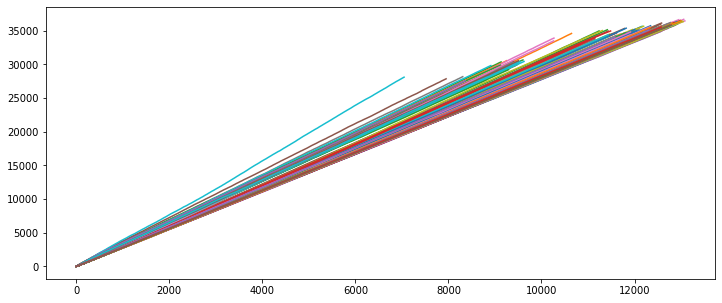

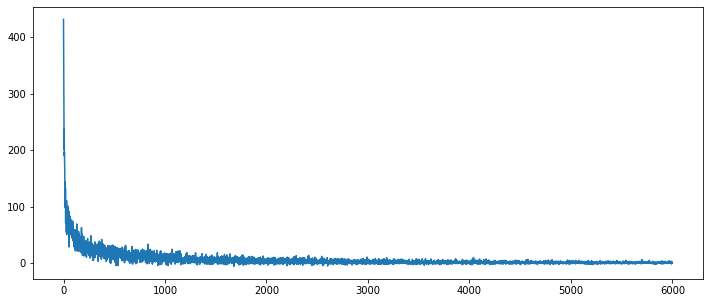

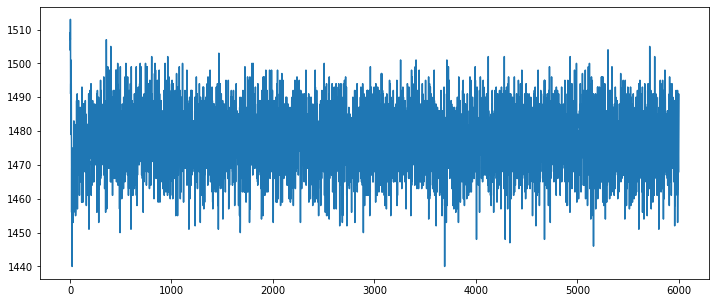

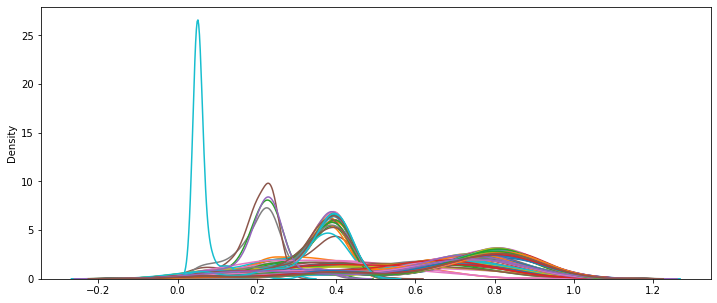

Run 9:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (131): 36604 (0.9538855678906917, CCCCCCCCCCCCCCCC)
WORST AGENT (247): 26520 (0.47190419792077903, DCDCCCCCDCCCCCCC)


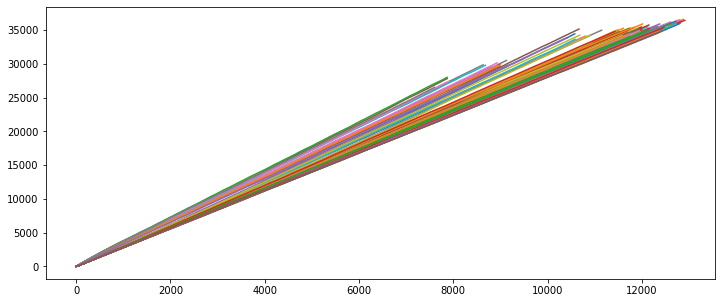

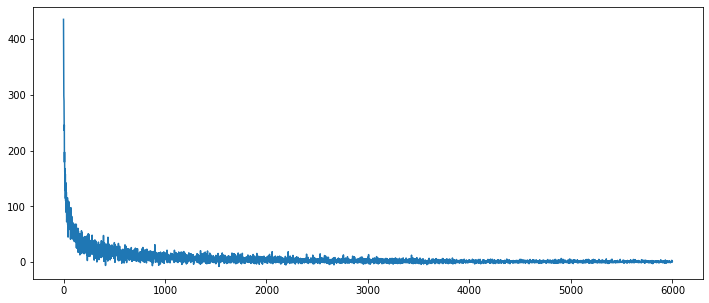

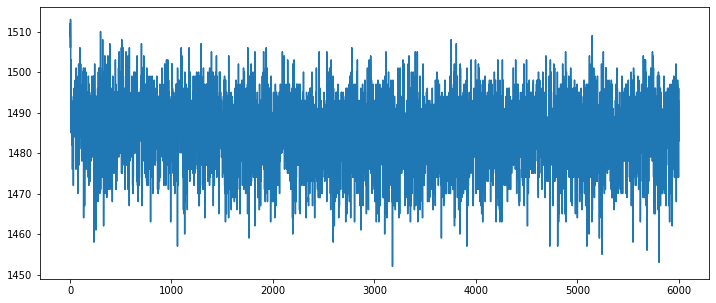

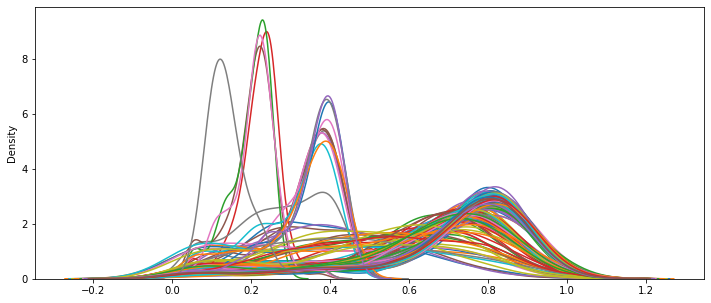

Run 10:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (200): 36722 (0.9382476308839521, CCCCCCCCCCCCCDCC)
WORST AGENT (28): 26326 (0.3880378313573998, DCDCCCCCCCDCCCCC)


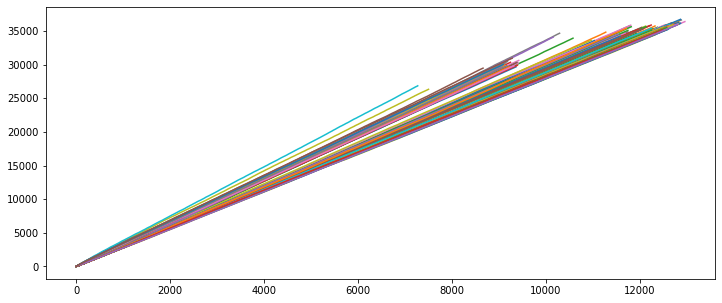

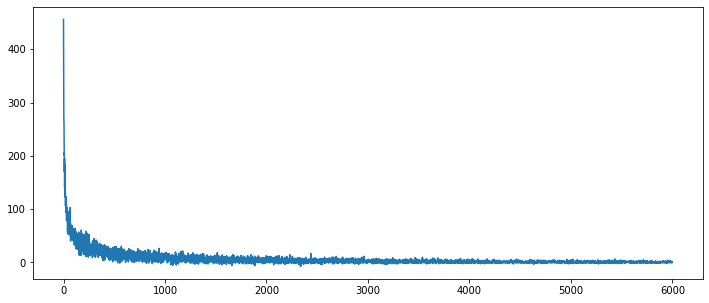

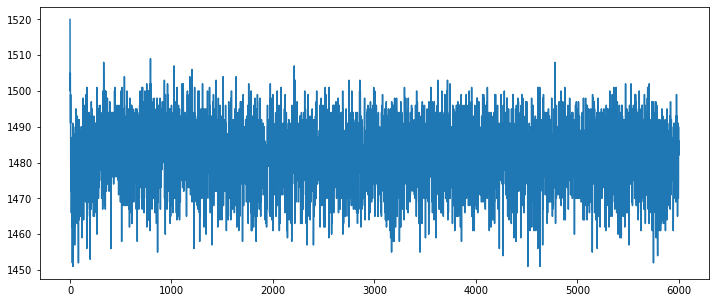

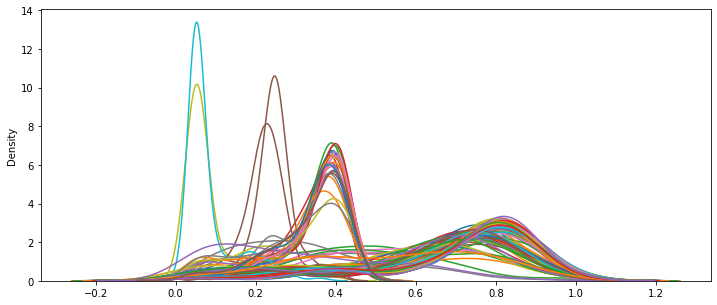

In [6]:
POPULATION = (256,)
ROUNDS = 6_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(10):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()

    M = sim.produce_weight_matrix()
    for row in M:
        sns.kdeplot(row)

    plt.show()

    


In [7]:
G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [8]:
# from datetime import datetime

# dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

# nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
M = sim.produce_weight_matrix()

M

array([[0.        , 0.8836    , 0.6232687 , ..., 0.84833795, 0.62673611,
        0.38525565],
       [0.8836    , 0.        , 0.47928994, ..., 0.87890625, 0.89197531,
        0.05      ],
       [0.6232687 , 0.47928994, 0.        , ..., 0.62520281, 0.73469388,
        0.40111111],
       ...,
       [0.84833795, 0.87890625, 0.62520281, ..., 0.        , 0.71818443,
        0.28994083],
       [0.62673611, 0.89197531, 0.73469388, ..., 0.71818443, 0.        ,
        0.40742417],
       [0.38525565, 0.05      , 0.40111111, ..., 0.28994083, 0.40742417,
        0.        ]])

In [11]:
import seaborn as sns

In [12]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.8836    , 0.6232687 , ..., 0.84833795, 0.62673611,
        0.38525565],
       [0.8836    , 0.05      , 0.47928994, ..., 0.87890625, 0.89197531,
        0.05      ],
       [0.6232687 , 0.47928994, 0.05      , ..., 0.62520281, 0.73469388,
        0.40111111],
       ...,
       [0.84833795, 0.87890625, 0.62520281, ..., 0.05      , 0.71818443,
        0.28994083],
       [0.62673611, 0.89197531, 0.73469388, ..., 0.71818443, 0.05      ,
        0.40742417],
       [0.38525565, 0.05      , 0.40111111, ..., 0.28994083, 0.40742417,
        0.05      ]])

In [13]:
# K = nx.Graph()
# K.add_weighted_edges_from([
#     (i, j, weights[i, j] + weights[j, i])
#     for i in range(POPULATION[0])
#     for j in range(i + 1, POPULATION[0])
#     if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
# ])

# nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [14]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Ac

In [15]:
cumulative_rewards[0][0]

200

In [16]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.81969943e+02 2.18503001e+02]
  [2.57574901e+02 3.66466888e+01]
  [2.31439303e+02 1.33485558e+01]
  [4.36298948e+01 2.50000000e-01]]

 [[2.73452896e+02 1.09650460e+02]
  [1.73732709e+02 9.08436600e+00]
  [1.16373775e+02 1.79424555e+00]
  [1.35411282e+01 0.00000000e+00]]

 [[2.62870794e+02 5.93590612e+01]
  [1.67567375e+02 5.53289768e+00]
  [7.98530636e+01 3.07940148e+01]
  [1.88182532e+01 0.00000000e+00]]

 [[1.51168319e+02 5.17086571e+00]
  [0.00000000e+00 6.67386362e+00]
  [3.84244160e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [17]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.COOPERATE: 0>

In [18]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[2.80112858e+02 2.12163465e+02]
  [2.57003728e+02 5.10271709e+01]
  [2.34529605e+02 1.65510250e+01]
  [5.48563874e+01 5.00000000e-02]]

 [[2.70328612e+02 7.25172621e+01]
  [1.83681119e+02 8.61696187e+00]
  [1.25772727e+02 7.73408093e-01]
  [6.46156326e+00 0.00000000e+00]]

 [[2.64690338e+02 6.39147265e+01]
  [1.70671006e+02 3.75615636e+00]
  [7.84008706e+01 3.28966826e+00]
  [7.66124504e+00 0.00000000e+00]]

 [[1.56363438e+02 0.00000000e+00]
  [1.94001936e+01 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]
  [2.65420650e+00 0.00000000e+00]]]


In [19]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [20]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [21]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

3.0                      CCCCCDCCCDCCCCCD
3.0                      CCCCCDCDCCCCCCCD
5.0                      CCCCCDCCCCCCCCCD
6.0                      CCCCCCCDCCCDCDCC
11.0                     CCCDCDCDCCCCCCCC
16.0                     CCCDCCCDCCCCDDCC
21.0                     CCCCCDDCCCCCCDCC
22.0                     CCDCCCDDCCCCCCCC
25.0                     CCCCCCDDCDCCCCCC
30.0                     CCCDCCCCCCCCCCDD
33.0                     CCCCCCCCCCDCCCDC
34.0                     CCCCCDCDCDCCCCCC
37.0                     CCCCCDCCCCCDDCCC
41.5                     CCCCCCCDCCCCCCCD
43.0                     CCDDCDCDCCCDCCCC
45.0                     CCCCCDCCDCDCCCCC
47.0                     CCCDCCCDCCCCCDCC
47.0                     CCCCCCDDCCCCCDCC
52.2                     CCCDCCCCCCCCDCCC
54.0                     CCCCCDDCCCCCCCCD
55.2                     CCCCCCDCCCCDCCCC
59.0                     CCCCCCCCCCCDCCDC
60.0                     CCCCCCCCCCCCCCDD
60.0                     CCCCCDCCC

In [22]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

36613.0                  CCCCCDCDCCCCCCCD
36513.0                  CCCCCDCCCCCCCCCD
36482.0                  CCCCCCCDCCCDCDCC
36403.0                  CCCCCDCCCDCCCCCD
36229.0                  CCCDCDCDCCCCCCCC
36191.0                  CCCDCCCDCCCCDDCC
36125.0                  CCDCCCDDCCCCCCCC
36087.0                  CCCCCCDDCDCCCCCC
36034.0                  CCCDCCCCCCCCCCDD
35962.0                  CCCCCDDCCCCCCDCC
35910.0                  CCCCCDCDCDCCCCCC
35894.0                  CCCCCDCCDCDCCCCC
35831.0                  CCCCCCCCCCDCCCDC
35820.0                  CCCCCCDCCCCDCCCC
35796.5                  CCCCCCCDCCCCCCCD
35784.0                  CCCDCCCDCCCCCDCC
35778.6                  CCCDCCCCCCCCDCCC
35766.0                  CCDDCDCDCCCDCCCC
35761.25                 CCCCCCCCCDCCCDCC
35733.0                  CCCCCDDCCCCCCCCD
35728.0                  CCCDCCDCCCCCDCDC
35721.0                  CCCDCCDDCCDCCCCC
35718.0                  CCCCCDCCCCCDDCCC
35717.742424242424       CCCCCDCCC

In [23]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCCCCCCCCDCC'

In [24]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.81969943e+02 2.18503001e+02]
  [2.57574901e+02 3.66466888e+01]
  [2.31439303e+02 1.33485558e+01]
  [4.36298948e+01 2.50000000e-01]]

 [[2.73452896e+02 1.09650460e+02]
  [1.73732709e+02 9.08436600e+00]
  [1.16373775e+02 1.79424555e+00]
  [1.35411282e+01 0.00000000e+00]]

 [[2.62870794e+02 5.93590612e+01]
  [1.67567375e+02 5.53289768e+00]
  [7.98530636e+01 3.07940148e+01]
  [1.88182532e+01 0.00000000e+00]]

 [[1.51168319e+02 5.17086571e+00]
  [0.00000000e+00 6.67386362e+00]
  [3.84244160e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]]


In [25]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => D
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
